In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import matplotlib.pyplot as plt


In [37]:
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 

In [38]:
#convert the join and end date to_date
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
#.replace(pd.NaT, np.nan).sort_values(by='End Date')

In [39]:
date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
dates = pd.date_range(date_min, date_max, freq = 'MS')
#dates

In [40]:
##we need to know each month kow many activemembers we have to calculate the churn 
##create the dataframe to help us calculate it
customers_total = pd.DataFrame({'Date':dates})

##add total month membership in dataframe subscriptions
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
##convert the difference in months
subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)


## Total members churn rate and growth membership

In [41]:
def add_count(join_date, duration, dates, members_count):
    index = (dates == join_date).argmax()
    
    for i in range(index,index + duration+1):
        members_count[i] = members_count[i] +1 
    
    return members_count

In [42]:
##create list with count of members in each month
members_count =  [0] * len(dates)
subscriptions.apply(lambda row: add_count(row['Join Date'], row['Duration'],
                                          dates, members_count), axis=1)

customers_total = customers_total.assign(Members= members_count)


## members join 
join_frame = subscriptions.groupby(['Join Date']).count()['CustomerID'].reset_index()
join_frame = join_frame.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
customers_total = pd.merge(customers_total, join_frame, on = 'Date', how='outer')
customers_total

##calulate membership growth =  number of new members subscription / total members
customers_total['Membership Growth']= customers_total['New Members'] / (customers_total['Members'] - customers_total['New Members'])
customers_total['Membership Growth'] =  customers_total['Membership Growth'].replace([np.inf, -np.inf], np.nan) 
#customers_total

## members leave 
end_frame = subscriptions.groupby(['End Date']).count()['CustomerID'].reset_index()
end_frame = end_frame.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
customers_total = pd.merge(customers_total, end_frame, on = 'Date', how='outer')
#customers_total

##calulate churn =  number of ending subscription / total members
customers_total['Churn']= customers_total['Cancellations'] / customers_total['Members']
#customers_total

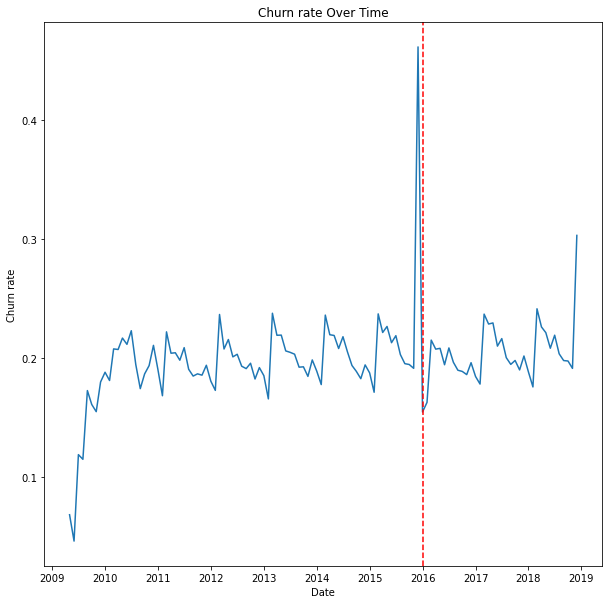

In [48]:
#Churn rate vs Time Graph
plt.figure(figsize=(10,10))
plt.plot(customers_total['Date'], customers_total['Churn'])
plt.title('Churn rate Over Time')
plt.ylabel('Churn rate')
plt.xlabel('Date')
plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
plt.show()

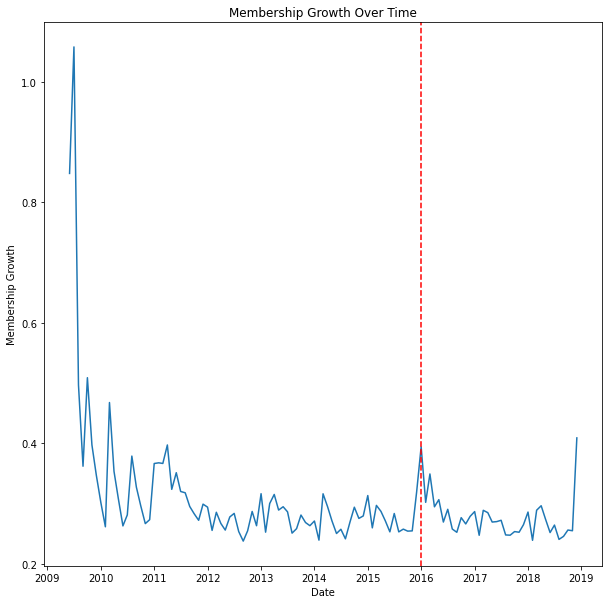

In [49]:
#Membership Growth vs Time Graph
plt.figure(figsize=(10,10))
plt.plot(customers_total['Date'], customers_total['Membership Growth'])
plt.title('Membership Growth Over Time')
plt.ylabel('Membership Growth')
plt.xlabel('Date')
plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
plt.show()

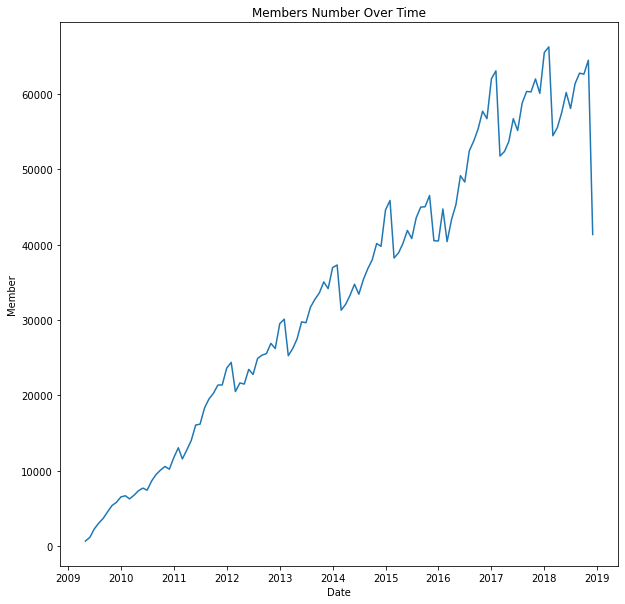

In [50]:
#Membership vs Time Graph
plt.figure(figsize=(10,10))
plt.plot(customers_total['Date'], customers_total['Members'])
plt.title('Members Number Over Time')
plt.ylabel('Member')
plt.xlabel('Date')
#plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
plt.show()

## Number of Clubs

In [51]:
#Changes in number of gyms
clubs = subscriptions.Club.unique()
members_count_club = {club:([0]*len(dates))  for club in clubs}
subscriptions_perclub = subscriptions.groupby(subscriptions.Club)
for club in clubs:
    subscriptions_perclub.get_group(club).apply(lambda row : add_count(row['Join Date'], row['Duration'],
                                                    dates, members_count_club[club]), axis=1 )

members_per_club = pd.DataFrame({'Date':dates,'Club':clubs[0], 'Members':members_count_club[clubs[0]]})

for club in clubs[1:]:
    club_list = [club]*len(dates);
    club_df = pd.DataFrame({'Date':dates,'Club':club_list, 'Members':members_count_club[club]})
    members_per_club = pd.merge(members_per_club, club_df, on = ['Date','Club','Members'], how='outer')

members_per_club['Members'] = members_per_club['Members'].replace(0,np.nan)
#members_per_club.to_csv(r'members_per_club.csv')

## members join per club
join_frame_club = subscriptions.groupby(['Join Date', 'Club']).count()['CustomerID'].reset_index()
join_frame_club = join_frame_club.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
members_per_club = pd.merge(members_per_club, join_frame_club, on = ['Date', 'Club'], how='outer')

##calulate membership growth =  number of new members subscription / total members
members_per_club['Membership Growth']= members_per_club['New Members'] / (members_per_club['Members'] - members_per_club['New Members'])
members_per_club['Membership Growth'] = members_per_club['Membership Growth'].replace([np.inf, -np.inf], np.nan) 

## members leave per club
cancel_frame_club = subscriptions.groupby(['End Date', 'Club']).count()['CustomerID'].reset_index()
cancel_frame_club = cancel_frame_club.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
members_per_club = pd.merge(members_per_club, cancel_frame_club, on = ['Date', 'Club'], how='outer')

##calulate churn =  number of ending subscription / total members
members_per_club['Churn']= members_per_club['Cancellations'] / members_per_club['Members']


members_per_club

,Date,Club,Members,New Members,Membership Growth,Cancellations,Churn
0,2009-05-01,Enfield,NaN,NaN,NaN,NaN,NaN
1,2009-06-01,Enfield,NaN,NaN,NaN,NaN,NaN
2,2009-07-01,Enfield,NaN,NaN,NaN,NaN,NaN
3,2009-08-01,Enfield,NaN,NaN,NaN,NaN,NaN
4,2009-09-01,Enfield,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3707,2018-08-01,Bexley,1771.0,355.0,0.250706,395.0,0.223038
3708,2018-09-01,Bexley,1772.0,332.0,0.230556,334.0,0.188488
3709,2018-10-01,Bexley,1788.0,373.0,0.263604,388.0,0.217002
3710,2018-11-01,Bexley,1826.0,395.0,0.276031,358.0,0.196057


In [52]:
## plot churn rates per club

# order clubs based on old
ordered_clubs = df[['Club', 'Join Date']].groupby(['Club']).min().sort_values(by='Join Date')
ordered_clubs = ordered_clubs.index.to_list()
ordered_clubs

# plot churn 
for interv in range(4, len(clubs)+1, 4):
    plt.figure(figsize=(15,15))  ##use subplot here 
    for club in clubs[interv-4:interv]:
        churn_club = members_per_club[members_per_club.Club == club]
        plt.plot(churn_club["Date"], churn_club["Churn"], label = club)
        print(club)
    plt.legend()


KeyError: "None of [Index(['Club', 'Join Date'], dtype='object')] are in the [columns]"

In [ ]:
#bar plot per club maybe a fun for window

data_increase_dates = members_per_club[ ( members_per_club.Date > 
                                       pd.to_datetime(('Sep-15').upper(), format='%b-%y', yearfirst=False) ) & 
                                     ( members_per_club.Date <
                                       pd.to_datetime(('Feb-17').upper(), format='%b-%y', yearfirst=False) ) ]

mean_churn_per_club = data_increase_dates.groupby('Club').Churn.agg(['mean'])

mean_churn_per_club.sort_values(by='mean',ascending=False).plot.bar(figsize=(15,15))

## Churn rate population breakdown

In [ ]:
#Changes in number of gyms
def get_members_churn_growth(column_name, traits, ):

    members_count_trait = {trait:([0]*len(dates))  for trait in traits}
    subscriptions_pertrait = subscriptions.groupby(subscriptions[column_name])
    for trait in traits:
        subscriptions_pertrait.get_group(trait).apply(lambda row : add_count(row['Join Date'], row['Duration'],
                                                        dates, members_count_trait[trait]), axis=1 )

    members_per_trait = pd.DataFrame({'Date':dates,column_name:traits[0], 'Members':members_count_trait[traits[0]]})

    for trait in traits[1:]:
        trait_list = [trait]*len(dates);
        trait_df = pd.DataFrame({'Date':dates, column_name:trait_list, 'Members':members_count_trait[trait]})
        members_per_trait = pd.merge(members_per_trait, trait_df, on = ['Date',column_name,'Members'], how='outer')

    members_per_trait['Members'] = members_per_trait['Members'].replace(0,np.nan)
    #members_per_trait.to_csv(r'members_per_trait.csv')

    ## members join per trait
    join_frame_trait = subscriptions.groupby(['Join Date', column_name]).count()['CustomerID'].reset_index()
    join_frame_trait = join_frame_trait.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
    members_per_trait = pd.merge(members_per_trait, join_frame_trait, on = ['Date', column_name], how='outer')

    ##calulate membership growth =  number of new members subscription / total members
    members_per_trait['Membership Growth']= members_per_trait['New Members'] / (members_per_trait['Members'] - members_per_trait['New Members'])
    members_per_trait['Membership Growth'] = members_per_trait['Membership Growth'].replace([np.inf, -np.inf], np.nan) 

    ## members leave per trait
    cancel_frame_trait = subscriptions.groupby(['End Date', column_name]).count()['CustomerID'].reset_index()
    cancel_frame_trait = cancel_frame_trait.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
    members_per_trait = pd.merge(members_per_trait, cancel_frame_trait, on = ['Date',column_name], how='outer')

    ##calulate churn =  number of ending subscription / total members
    members_per_trait['Churn']= members_per_trait['Cancellations'] / members_per_trait['Members']

    return members_per_trait

In [ ]:
def plot_all_levels_(traits, members_per_trait, column_name, behaviour):
    plt.figure(figsize=(15,15))  
    for trait in traits:
        df_trait = members_per_trait[members_per_trait[column_name] == trait]
        plt.plot(df_trait["Date"], df_trait[behaviour], label = trait, alpha=0.7)
    plt.legend()

In [ ]:
def plot_all_levels_churn(traits, members_per_trait, column_name):
    plot_all_levels_(traits, members_per_trait, column_name, "Churn")

In [ ]:
def plot_all_levels_growth(traits, members_per_trait, column_name):
    plot_all_levels_(traits, members_per_trait, column_name, "Membership Growth")

In [ ]:
#gender trait
genders = subscriptions.Gender.unique()
members_per_gender = get_members_churn_growth('Gender', genders)
members_per_gender = get_members_churn_growth('Gender', genders)
plot_all_levels_churn(genders, members_per_gender, 'Gender')

In [ ]:
#affluence trait
affluences = subscriptions.Affluence.unique()
members_per_affluence = get_members_churn_growth('Affluence', affluences)
members_per_affluence = get_members_churn_growth('Affluence', affluences)

plot_all_levels_churn(affluences, members_per_affluence, 'Affluence')

In [ ]:
#Subscrition trait
subc_types = subscriptions['Subscription Type'].unique()
members_per_subc_types = get_members_churn_growth('Subscription Type', subc_types)
members_per_subc_types = get_members_churn_growth('Subscription Type', subc_types)
plot_all_levels_churn(subc_types, members_per_subc_types, 'Subscription Type')

# Age Bucket


In [13]:
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Duration
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,0
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,6
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,7
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,7


In [14]:
# join and end age
subscriptions["Join Age"] = pd.DatetimeIndex(subscriptions["Join Date"]).year - subscriptions["BirthYear"]
subscriptions['End Age'] = np.where(subscriptions['End Date'].isna(),
                                ((date_max.year - subscriptions['BirthYear']) ), 
                                (pd.DatetimeIndex(subscriptions['End Date']).year - subscriptions['BirthYear']) ).astype(int)


In [15]:
#define age buckets
age_limits = [24, 30, 40]

conditions = [
    (subscriptions['Join Age'] <= age_limits[0]),
    (subscriptions['Join Age'] > age_limits[0]) & (subscriptions['Join Age'] <= age_limits[1]),
    (subscriptions['Join Age'] > age_limits[1]) & (subscriptions['Join Age'] <= age_limits[2]),
    (subscriptions['Join Age'] > age_limits[2])     ]

# create a list of the values we want to assign for each condition
values = ['tier_1', 'tier_2', 'tier_3', 'tier_4']

subscriptions['Join Age Tier'] = np.select(conditions, values)


In [16]:
subscriptions.groupby('Join Age Tier').count()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Duration,Join Age,End Age
Join Age Tier,,,,,,,,,,,
tier_1,180408,180408,180408,180408,180408,170598,180408,180408,180408,180408,180408
tier_2,231808,231808,231808,231808,231808,218004,231808,231808,231808,231808,231808
tier_3,334787,334787,334787,334787,334787,312997,334787,334787,334787,334787,334787
tier_4,103030,103030,103030,103030,103030,96057,103030,103030,103030,103030,103030


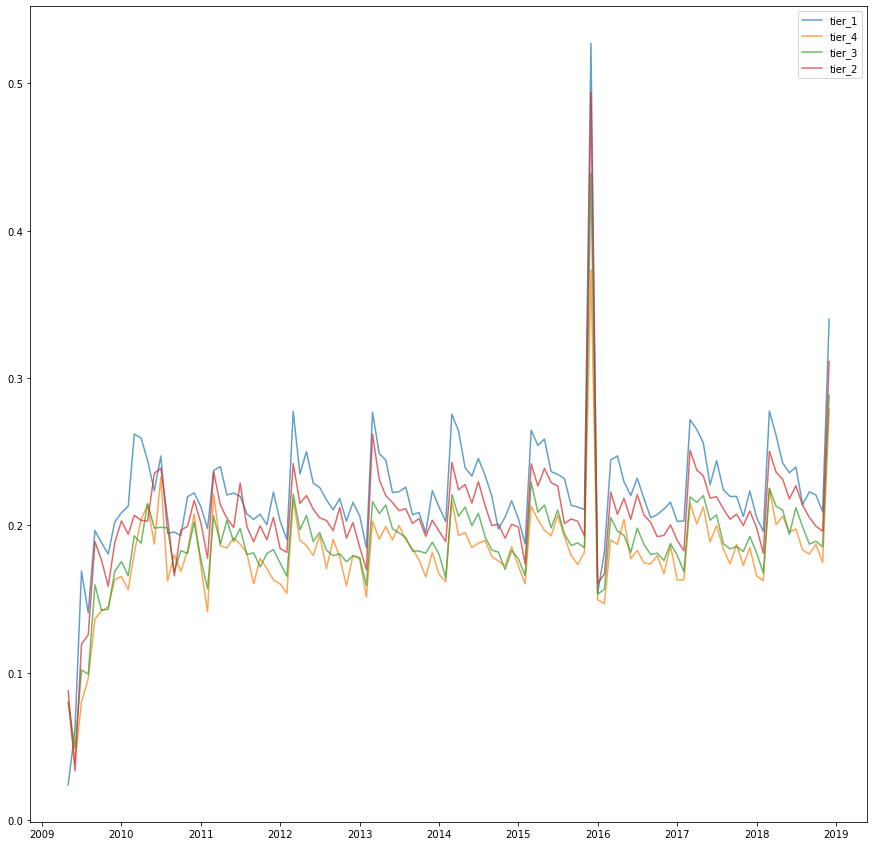

In [83]:
#Join Age churn
age = subscriptions['Join Age Tier'].unique()
members_per_age = get_members_churn_growth('Join Age Tier', age)
members_per_age = get_members_churn_growth('Join Age Tier', age)
plot_all_levels_churn(age, members_per_age, 'Join Age Tier')

In [84]:
mask = ( subscriptions['JoinAge tier'] == '0' ) 
df_1 = subscriptions[mask]



# Group intersection churn rate

In [24]:
affluence_levels = subscriptions['Affluence'].unique()
gender_levels = subscriptions['Gender'].unique()
joinagetier_levels = subscriptions['Join Age Tier'].unique()

affluence_levels, gender_levels, joinagetier_levels

(array(['C1', 'A', 'B', 'C2', 'DE'], dtype=object),
 array(['Male', 'Female'], dtype=object),
 array(['tier_1', 'tier_4', 'tier_3', 'tier_2'], dtype=object))

In [25]:
subscriptions['Affluence_Gender'] = subscriptions['Affluence'] +'_' + subscriptions['Gender']
subscriptions['Affluence_Gender'].unique()

subscriptions['Affluence_Age'] = subscriptions['Affluence'] +'_' + subscriptions['Join Age Tier']
subscriptions['Affluence_Age'].unique()

subscriptions['Gender_Age'] = subscriptions['Gender'] +'_' + subscriptions['Join Age Tier']
subscriptions['Gender_Age'].unique()

subscriptions['Affluence_Gender_Age'] = subscriptions['Affluence'] +'_' + subscriptions['Gender'] + '_' + subscriptions['Join Age Tier']
subscriptions['Affluence_Gender_Age'].unique()

array(['C1_Male_tier_1', 'A_Female_tier_4', 'B_Female_tier_3',
       'C1_Female_tier_4', 'C2_Male_tier_3', 'C1_Male_tier_3',
       'B_Female_tier_2', 'C1_Male_tier_4', 'B_Male_tier_2',
       'C2_Female_tier_1', 'A_Female_tier_3', 'B_Female_tier_1',
       'DE_Male_tier_2', 'B_Male_tier_3', 'A_Male_tier_3',
       'A_Female_tier_2', 'C2_Female_tier_2', 'A_Male_tier_1',
       'B_Female_tier_4', 'B_Male_tier_1', 'C1_Female_tier_1',
       'C1_Female_tier_2', 'DE_Male_tier_3', 'C2_Male_tier_4',
       'C1_Female_tier_3', 'C2_Male_tier_1', 'A_Male_tier_2',
       'C2_Female_tier_4', 'C1_Male_tier_2', 'A_Female_tier_1',
       'A_Male_tier_4', 'C2_Female_tier_3', 'C2_Male_tier_2',
       'B_Male_tier_4', 'DE_Female_tier_3', 'DE_Female_tier_1',
       'DE_Female_tier_2', 'DE_Male_tier_4', 'DE_Female_tier_4',
       'DE_Male_tier_1'], dtype=object)

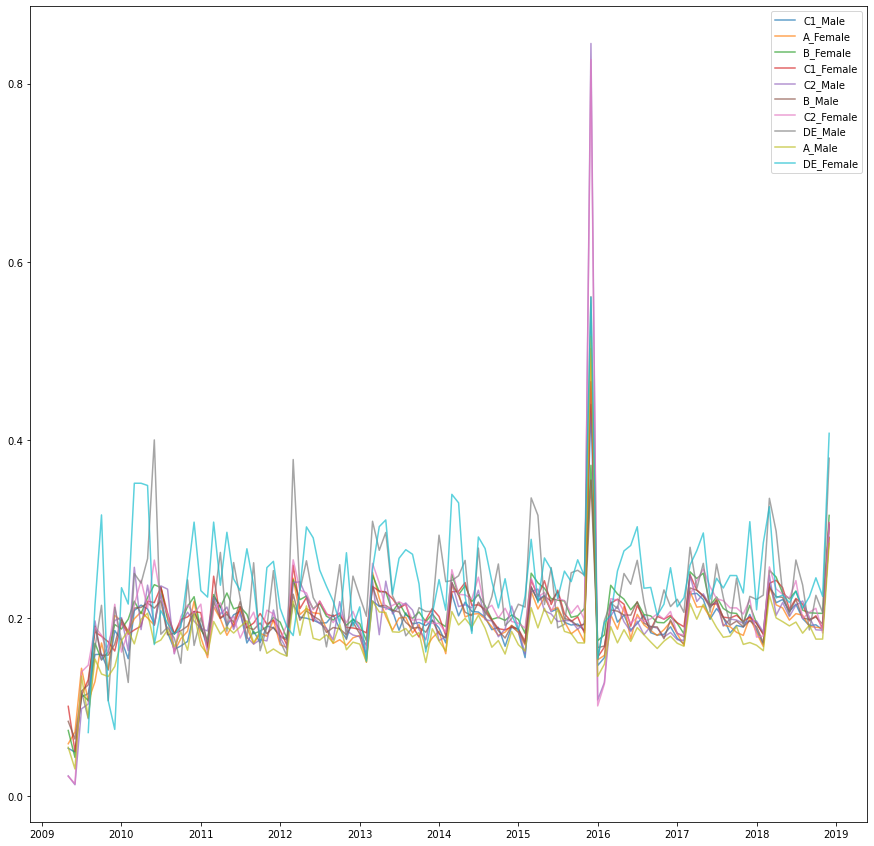

In [35]:
#Affluence Gender churn
trait_types = subscriptions['Affluence_Gender'].unique()
members_per_trait = get_members_churn_growth('Affluence_Gender', trait_types)
members_per_trait = get_members_churn_growth('Affluence_Gender', trait_types)
plot_all_levels_churn(trait_types, members_per_trait, 'Affluence_Gender')

In [ ]:
members_per_trait

In [40]:
def plot_all_levels_members_proportion(traits, members_per_trait, column_name):
    members_total = members_per_trait.groupby('Date')["Members"].sum().rename("Members_Total").reset_index()
    df = members_per_trait
    df = df.merge(members_total)
    df["Member proportion"] = df["Members"] / df["Members_Total"]

    plt.figure(figsize=(15,15))  
    for trait in traits:
        df_trait = df[df[column_name] == trait]
        plt.plot(df_trait["Date"], df_trait["Member proportion"], label = trait, alpha=0.7)
    plt.legend()

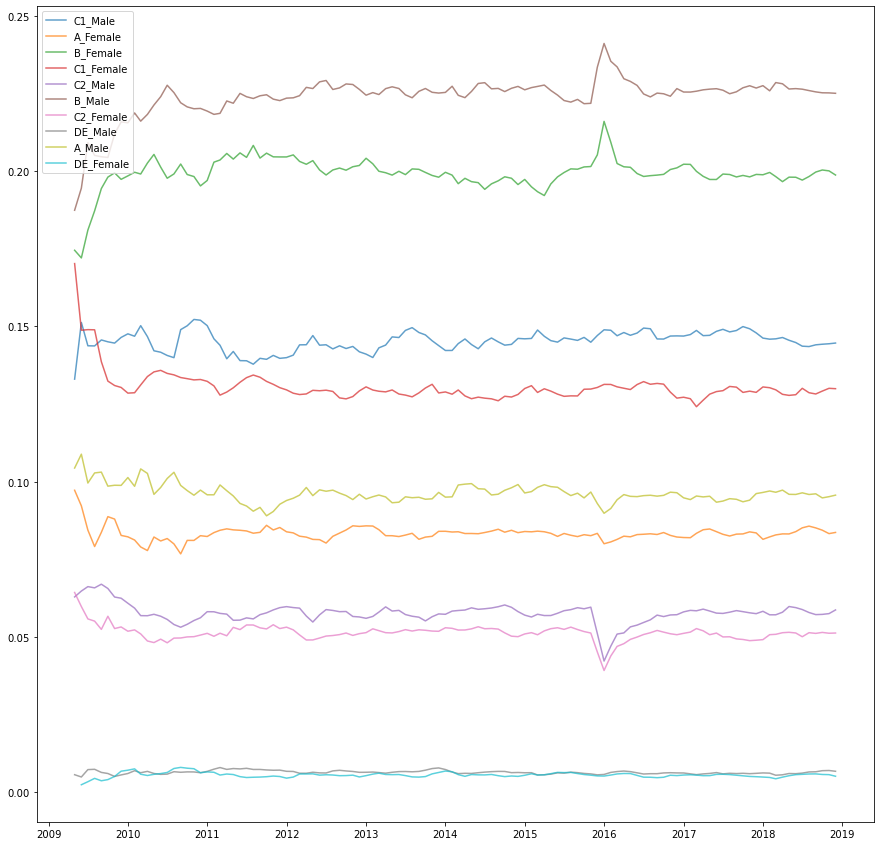

In [41]:
plot_all_levels_members_proportion(trait_types, members_per_trait, 'Affluence_Gender')


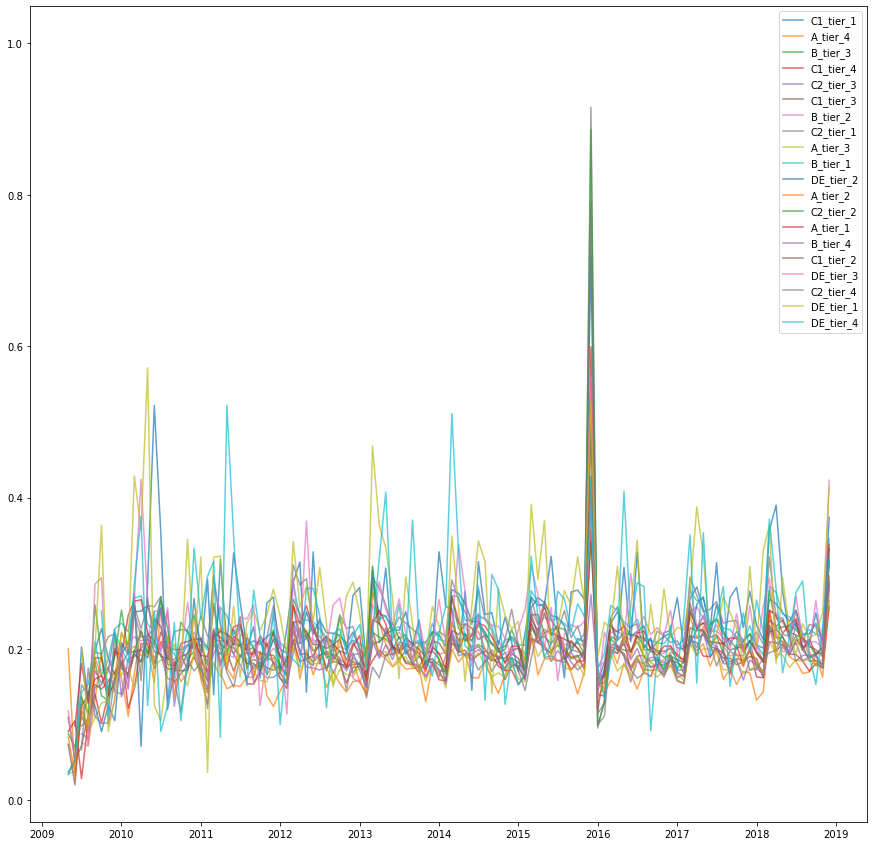

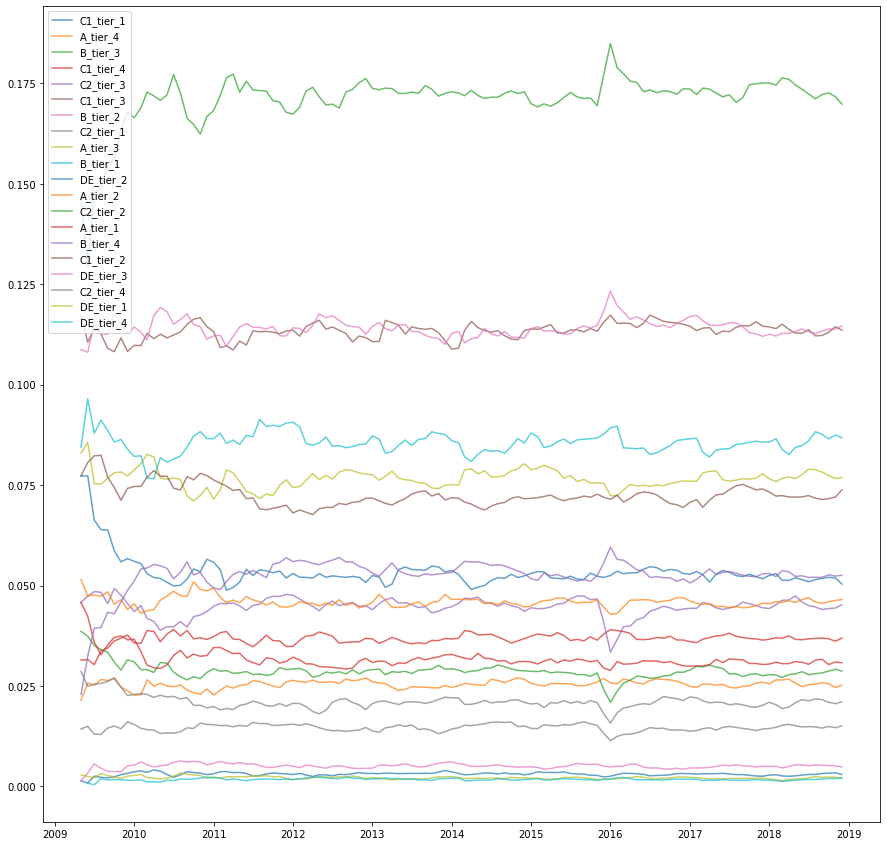

In [42]:
trait_types = subscriptions['Affluence_Age'].unique()
members_per_trait = get_members_churn_growth('Affluence_Age', trait_types)
members_per_trait = get_members_churn_growth('Affluence_Age', trait_types)
plot_all_levels_churn(trait_types, members_per_trait, 'Affluence_Age')
plot_all_levels_members_proportion(trait_types, members_per_trait, 'Affluence_Age')

In [43]:
#Affluence Gender churn
trait_types = subscriptions['Gender_Age'].unique()
members_per_trait = get_members_churn_growth('Gender_Age', trait_types)
members_per_trait = get_members_churn_growth('Gender_Age', trait_types)
plot_all_levels_churn(trait_types, members_per_trait, 'Gender_Age')
plot_all_levels_members_proportion(trait_types, members_per_trait, 'Gender_Age')

KeyboardInterrupt: 

In [ ]:
#Affluence Gender churn
trait_types = subscriptions['Affluence_Gender_Age'].unique()
members_per_trait = get_members_churn_growth('Affluence_Gender_Age', trait_types)
members_per_trait = get_members_churn_growth('Affluence_Gender_Age', trait_types)
plot_all_levels_churn(trait_types, members_per_trait, 'Affluence_Gender_Age')
plot_all_levels_members_proportion(trait_types, members_per_trait, 'Affluence_Gender_Age')

# Club category group

In [46]:
oldest_clubs = subscriptions[['Club', 'Join Date']].groupby(['Club']).min().sort_values(by='Join Date')
oldest_clubs_list = oldest_clubs.index.to_list()
oldest_clubs_list,oldest_clubs

(['Hounslow',
  'Greenwich',
  'Richmond upon Thames',
  'Enfield',
  'Lambeth',
  'Harrow',
  'Barnet',
  'Islington',
  'Havering',
  'Westminster',
  'Tower Hamlets',
  'Camden',
  'Haringey',
  'Sutton',
  'Waltham Forest',
  'Croydon',
  'Wandsworth',
  'Southwark',
  'Newham',
  'Brent',
  'Ealing',
  'Lewisham',
  'Bexley',
  'Hackney',
  'Barking',
  'Kingston upon Thames',
  'Merton',
  'Bromley',
  'Kensington and Chelsea',
  'Hammersmith',
  'Hillingdon',
  'Redbridge'],
                         Join Date
 Club                             
 Hounslow               2009-05-01
 Greenwich              2009-07-01
 Richmond upon Thames   2009-10-01
 Enfield                2010-03-01
 Lambeth                2010-08-01
 Harrow                 2011-01-01
 Barnet                 2011-02-01
 Islington              2011-04-01
 Havering               2011-06-01
 Westminster            2011-08-01
 Tower Hamlets          2011-12-01
 Camden                 2012-06-01
 Haringey              

In [56]:
 #define  buckets
tier1 = ["Hounslow","Greenwich","Richmond upon Thames"]
tier2 = ["Enfield", "Lambeth", "Harrow", "Barnet", "Islington", "Havering", "Westminster","Tower Hamlets"]
tier3 = ["Camden", "Haringey", "Sutton", "Waltham Forest", "Croydon", "Wandsworth","Southwark","Newham", "Brent", "Ealing"]
tier4 = ["Lewisham",  "Bexley", "Hackney",  "Barking", "Kingston upon Thames",  "Merton", "Bromley", "Kensington and Chelsea"]
tier5 = [ "Hammersmith", "Hillingdon", "Redbridge"]
        
conditions = [
    (subscriptions['Club'].isin(tier1)),
    (subscriptions['Club'].isin(tier2)),
    (subscriptions['Club'].isin(tier3)),
    (subscriptions['Club'].isin(tier4)),
    (subscriptions['Club'].isin(tier5)),    
    ]

# create a list of the values we want to assign for each condition
values = ['tier_1', 'tier_2', 'tier_3', 'tier_4', 'tier_5']

subscriptions['Club_Category'] = np.select(conditions, values)
subscriptions

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Duration,Join Age,End Age,Join Age Tier,Affluence_Gender,Affluence_Age,Gender_Age,Affluence_Gender_Age,Club category,Club Category,Club_Category
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,0,19,19,tier_1,C1_Male,C1_tier_1,Male_tier_1,C1_Male_tier_1,tier_2,tier_2,tier_2
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,6,46,46,tier_4,A_Female,A_tier_4,Female_tier_4,A_Female_tier_4,tier_1,tier_1,tier_1
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,7,33,33,tier_3,B_Female,B_tier_3,Female_tier_3,B_Female_tier_3,tier_2,tier_2,tier_2
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2,43,43,tier_4,C1_Female,C1_tier_4,Female_tier_4,C1_Female_tier_4,tier_1,tier_1,tier_1
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,7,33,33,tier_3,C2_Male,C2_tier_3,Male_tier_3,C2_Male_tier_3,tier_2,tier_2,tier_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850028,Lewisham,2018-12-01,A,Male,Standard,NaT,850029,1995,0,23,23,tier_1,A_Male,A_tier_1,Male_tier_1,A_Male_tier_1,tier_4,tier_4,tier_4
850029,Tower Hamlets,2013-10-01,B,Male,Standard,2014-02-01,850030,1987,4,26,27,tier_2,B_Male,B_tier_2,Male_tier_2,B_Male_tier_2,tier_2,tier_2,tier_2
850030,Redbridge,2018-05-01,C1,Female,Standard,2018-09-01,850031,1985,4,33,33,tier_3,C1_Female,C1_tier_3,Female_tier_3,C1_Female_tier_3,tier_5,tier_5,tier_5
850031,Camden,2017-07-01,B,Female,Standard,2017-09-01,850032,1978,2,39,39,tier_3,B_Female,B_tier_3,Female_tier_3,B_Female_tier_3,tier_3,tier_3,tier_3


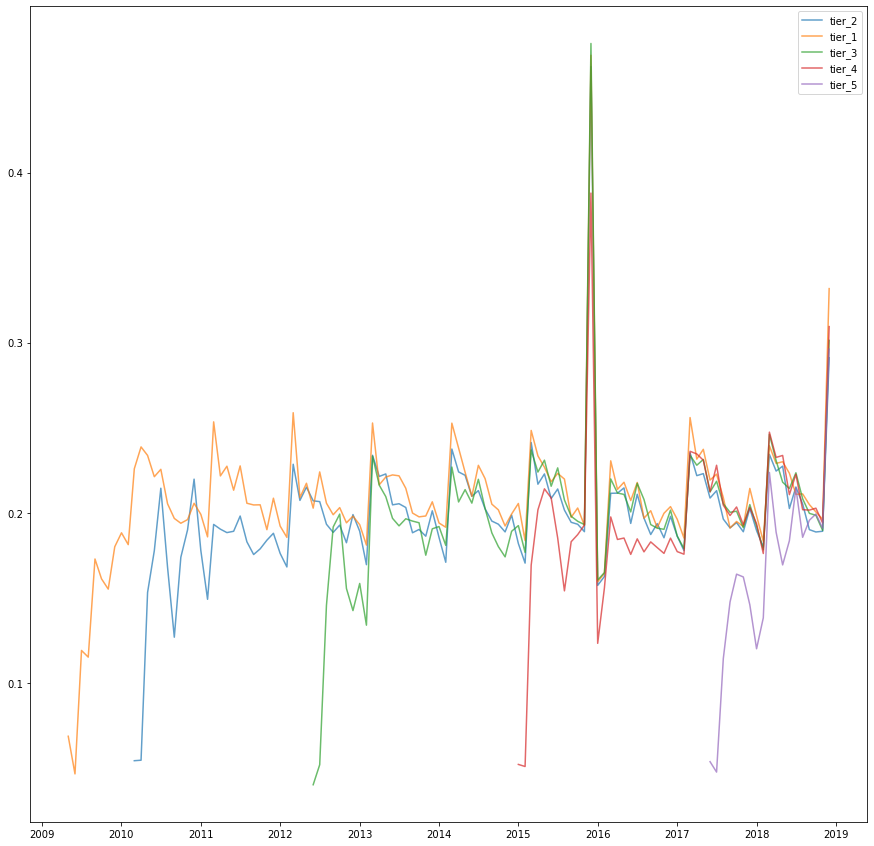

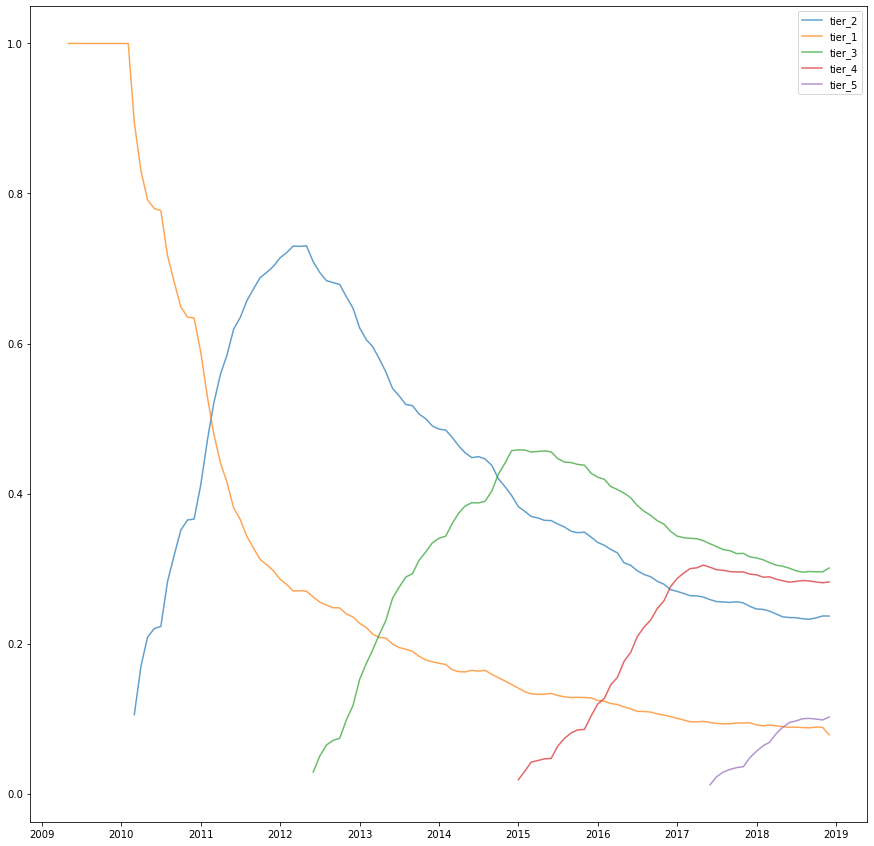

In [57]:
#Affluence Gender churn
trait_types = subscriptions['Club_Category'].unique()
members_per_trait = get_members_churn_growth('Club_Category', trait_types)
members_per_trait = get_members_churn_growth('Club_Category', trait_types)
plot_all_levels_churn(trait_types, members_per_trait, 'Club_Category')
plot_all_levels_members_proportion(trait_types, members_per_trait, 'Club_Category')

# Seasonality 

In [43]:
customers_total

,Date,Members,New Members,Membership Growth,Cancellations,Churn
0,2009-05-01,699,699,NaN,48,0.068670
1,2009-06-01,1203,552,0.847926,56,0.046550
2,2009-07-01,2309,1187,1.057932,275,0.119099
3,2009-08-01,3082,1023,0.496843,355,0.115185
4,2009-09-01,3714,987,0.361936,642,0.172859
...,...,...,...,...,...,...
111,2018-08-01,61301,11885,0.240509,12488,0.203716
112,2018-09-01,62702,12360,0.245521,12418,0.198048
113,2018-10-01,62570,12755,0.256047,12369,0.197683
114,2018-11-01,64422,13084,0.254860,12336,0.191487


In [44]:
import statsmodels.api as sm
from statsmodels.api import OLS

df = customers_total

df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df

,index,Members,New Members,Membership Growth,Cancellations,Churn
Date,,,,,,
2009-05-01,0,699,699,NaN,48,0.068670
2009-06-01,1,1203,552,0.847926,56,0.046550
2009-07-01,2,2309,1187,1.057932,275,0.119099
2009-08-01,3,3082,1023,0.496843,355,0.115185
2009-09-01,4,3714,987,0.361936,642,0.172859
...,...,...,...,...,...,...
2018-08-01,111,61301,11885,0.240509,12488,0.203716
2018-09-01,112,62702,12360,0.245521,12418,0.198048
2018-10-01,113,62570,12755,0.256047,12369,0.197683


In [45]:
#s=sm.tsa.seasonal_decompose(df.Churn)

decomposition = sm.tsa.seasonal_decompose(df.Churn, model='additive', period = 10)
#print(decomposition.trend)
#print(decomposition.seasonal)
#print(decomposition.resid)
#print(decomposition.observed)

In [46]:
x, y = np.arange(len(decomposition.trend.dropna())), decomposition.trend.dropna()
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                  trend   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     51.13
Date:                Sat, 23 Jan 2021   Prob (F-statistic):           1.24e-10
Time:                        16:55:27   Log-Likelihood:                 351.28
No. Observations:                 106   AIC:                            -698.6
Df Residuals:                     104   BIC:                            -693.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1910      0.002    111.434      0.0

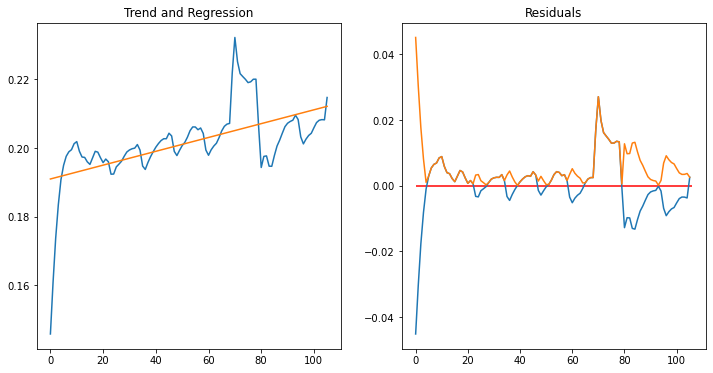

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(decomposition.trend.dropna().values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(decomposition.trend.dropna()))])
ax[1].plot(res.resid.values);
ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='r');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");